<a href="https://colab.research.google.com/github/Giovanni-LN/Projeto_RN/blob/main/Rede_VGG16_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar e preparar o Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho para o dataset no Google Drive
data_dir = "/content/drive/MyDrive/MyFoodDataset"

# Transformações para normalização e Data Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
        transforms.RandomRotation(10),      # Rotação aleatória
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalização
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Carregar as imagens
image_datasets = {
    x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Criar DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val', 'test']
}

# Verificar as classes
class_names = image_datasets['train'].classes
print("Classes detectadas:", class_names)

# Testar carregamento de um batch
images, labels = next(iter(dataloaders['train']))
print("Tamanho do batch:", images.shape)


Mounted at /content/drive
Classes detectadas: ['apple', 'bean', 'boiled', 'chicken', 'fried', 'lunch', 'rice', 'salad', 'spaghetti', 'steak']
Tamanho do batch: torch.Size([32, 3, 224, 224])


# Mapear as Classes

In [ ]:
class_mapping = {
    'apple': 'Maçã',
    'bean': 'Feijão',
    'boiled': 'Ovo Cozido',
    'chicken': 'Peito de Frango',
    'fried': 'Ovo Frito',
    'lunch': 'Almoço',
    'rice': 'Arroz',
    'salad': 'Salada',
    'spaghetti': 'Macarrão',
    'steak': 'Carne Assada'
}

# Criar a lista de classes traduzidas
filtered_class_names = [class_mapping[cls] for cls in class_names]
print("Classes finais mapeadas:", filtered_class_names)


Classes finais mapeadas: ['Maçã', 'Feijão', 'Ovo Cozido', 'Peito de Frango', 'Ovo Frito', 'Almoço', 'Arroz', 'Salada', 'Macarrão', 'Carne Assada']


# Verificar se os dados carregados e o mapeamento das classes estão funcionando

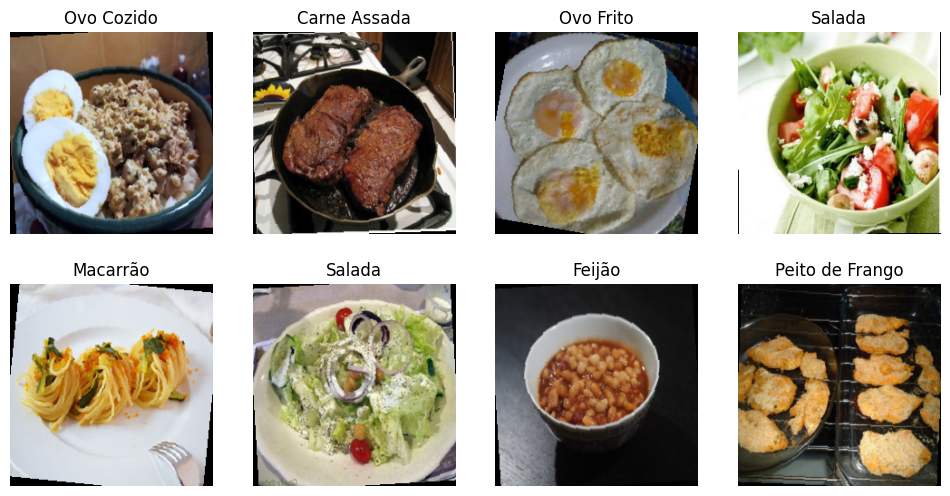

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Função para mostrar um batch de imagens
def imshow(inp, title=None):
    """Imprime uma imagem do tensor"""
    inp = inp.numpy().transpose((1, 2, 0))  # Ajusta para formato correto (Altura, Largura, Canais)
    mean = np.array([0.5, 0.5, 0.5])  # Valores usados na normalização
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean  # Desfaz a normalização
    inp = np.clip(inp, 0, 1)  # Garante que os valores estão no intervalo [0,1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# Pegar um batch do dataloader de treino
inputs, labels = next(iter(dataloaders['train']))

# Criar grid com algumas imagens
fig = plt.figure(figsize=(12, 6))
for i in range(8):  # Exibir 8 imagens
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    imshow(inputs[i])
    ax.set_title(filtered_class_names[labels[i].item()])  # Nome traduzido da classe

plt.show()


# Carregar o modelo VGG16 pré-treinado

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Definir o dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Carregar o modelo VGG16 pré-treinado
model_vgg16 = models.vgg16(pretrained=True)

# Modificar a última camada para 10 classes
num_classes = 10
model_vgg16.classifier[5] = nn.Dropout(0.5)  # Dropout antes da última camada
model_vgg16.classifier[6] = nn.Linear(4096, num_classes)

# Enviar o modelo para o dispositivo escolhido
model_vgg16 = model_vgg16.to(device)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.parameters(), lr=0.0001)

# Mostrar a estrutura do modelo modificado
print(model_vgg16)


Usando dispositivo: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Função de Treino VGG16

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"\n Época {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Modo de treino
            else:
                model.eval()  # Modo de validação

            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct.double() / total

            print(f"{phase} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    return model


# Executar o Treinamento VGG16

In [ ]:
model_vgg16 = train_model(model_vgg16, dataloaders, criterion, optimizer, num_epochs=30)



 Época 1/30
train | Loss: 1.0237 | Acc: 0.6773
val | Loss: 0.4151 | Acc: 0.8680

 Época 2/30
train | Loss: 0.2743 | Acc: 0.9187
val | Loss: 0.2357 | Acc: 0.9360

 Época 3/30
train | Loss: 0.2454 | Acc: 0.9147
val | Loss: 0.2793 | Acc: 0.9360

 Época 4/30
train | Loss: 0.1218 | Acc: 0.9613
val | Loss: 0.3454 | Acc: 0.9280

 Época 5/30
train | Loss: 0.0931 | Acc: 0.9707
val | Loss: 0.1377 | Acc: 0.9440

 Época 6/30
train | Loss: 0.0875 | Acc: 0.9733
val | Loss: 0.3233 | Acc: 0.9240

 Época 7/30
train | Loss: 0.0613 | Acc: 0.9787
val | Loss: 0.2374 | Acc: 0.9520

 Época 8/30
train | Loss: 0.0627 | Acc: 0.9813
val | Loss: 0.2829 | Acc: 0.9360

 Época 9/30
train | Loss: 0.1450 | Acc: 0.9560
val | Loss: 0.3376 | Acc: 0.9200

 Época 10/30
train | Loss: 0.0788 | Acc: 0.9747
val | Loss: 0.3383 | Acc: 0.9120

 Época 11/30
train | Loss: 0.0682 | Acc: 0.9813
val | Loss: 0.3363 | Acc: 0.9320

 Época 12/30
train | Loss: 0.0449 | Acc: 0.9880
val | Loss: 0.3886 | Acc: 0.9160

 Época 13/30
train | Los

# Avaliação do Modelo no Conjunto de Teste VGG16

In [ ]:
def evaluate_model_with_dropout(model, dataloader, criterion, device):
    model.train()  # Manter Dropout ativado

    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    print(f" Test Loss: {epoch_loss:.4f} | Test Acc: {epoch_acc:.4f}")
    return epoch_acc


# Cálculo da Média e Desvio Padrão da Acurácia VGG16

In [ ]:
import numpy as np

num_runs = 5  # Número de execuções para calcular média e desvio padrão
accuracies = []

for i in range(num_runs):
    print(f"Execução {i+1}/{num_runs}...")
    acc = evaluate_model_with_dropout(model_vgg16, dataloaders['test'], criterion, device)
    accuracies.append(acc)

# Cálculo da média e do desvio padrão
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"\n Média da Acurácia: {mean_acc:.4f}")
print(f" Desvio Padrão da Acurácia: {std_acc:.4f}")


Execução 1/5...
 Test Loss: 0.8937 | Test Acc: 0.8720
Execução 2/5...
 Test Loss: 0.9274 | Test Acc: 0.8640
Execução 3/5...
 Test Loss: 0.8692 | Test Acc: 0.8520
Execução 4/5...
 Test Loss: 0.9284 | Test Acc: 0.8600
Execução 5/5...
 Test Loss: 0.8899 | Test Acc: 0.8640

 Média da Acurácia: 0.8624
 Desvio Padrão da Acurácia: 0.0065


# Matriz de confusão normalizada VGG16

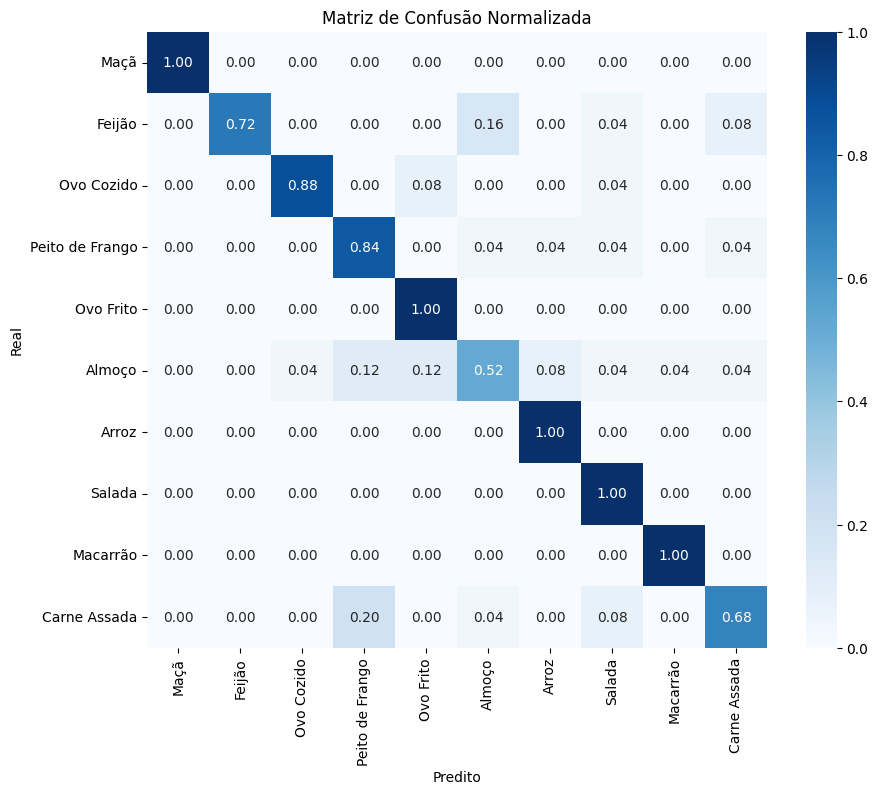

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Criar matriz de confusão normalizada
    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão Normalizada')
    plt.show()

# Chamar a função para gerar a matriz de confusão
plot_confusion_matrix(model_vgg16, dataloaders['test'], filtered_class_names, device)


# Predição de imagem para classe individual VGG16

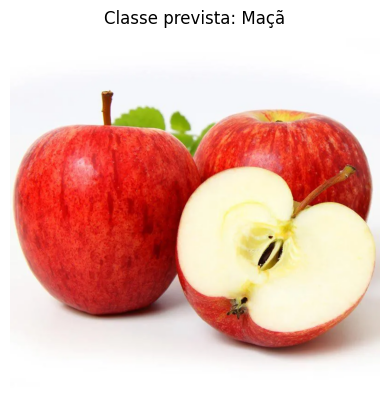

Classe prevista: Maçã


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(image_path, model, class_names, device):
    """Realiza a predição da classe de uma única imagem."""

    # Transformações da imagem (mesmas do conjunto de teste)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Carregar e transformar a imagem
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Adiciona dimensão do batch

    # Modo de avaliação
    model.eval()

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    # Exibir a imagem e a classe prevista
    plt.imshow(image)
    plt.title(f"Classe prevista: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

# Exemplo de uso
image_path = "/content/drive/MyDrive/MyFoodDataset/apple.webp"  # Substituir pelo caminho real da imagem
predicted_class = predict_image(image_path, model_vgg16, filtered_class_names, device)
print("Classe prevista:", predicted_class)


# T-SNE e PCA VGG16

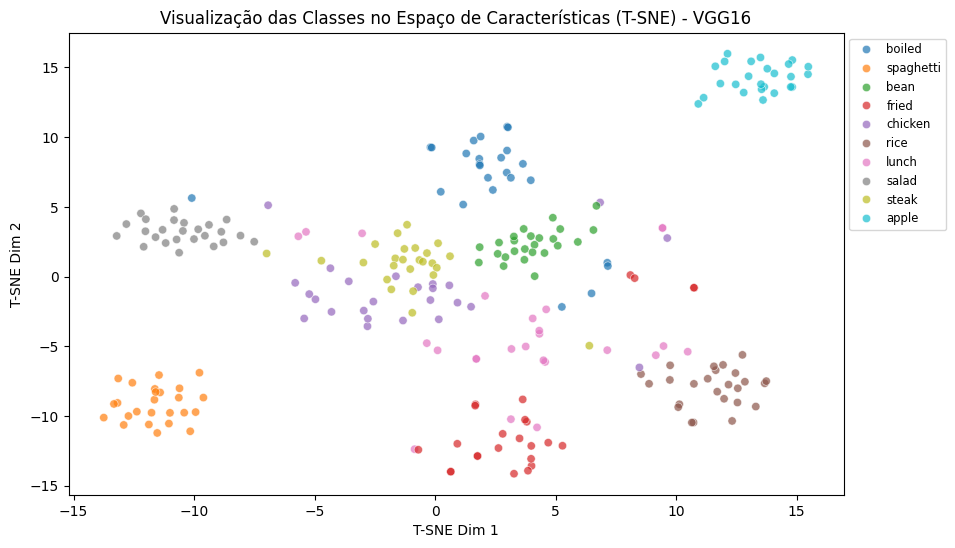

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_features(model, dataloader, device):
    model.eval()
    features, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            # Extraindo a saída da penúltima camada do VGG16
            feat = model.features(inputs)
            feat = torch.flatten(feat, start_dim=1)  # Achatar para um vetor

            features.append(feat.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)

    return features, labels_list

# Extrai os embeddings do modelo VGG16
features, labels = extract_features(model_vgg16, dataloaders['test'], device)

# PCA para redução de dimensionalidade inicial
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Aplicar T-SNE para visualizar em 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=[class_names[i] for i in labels], palette="tab10", alpha=0.7)
plt.xlabel("T-SNE Dim 1")
plt.ylabel("T-SNE Dim 2")
plt.title("Visualização das Classes no Espaço de Características (T-SNE) - VGG16")
plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1, 1))
plt.show()
